<h1 align="center">Advanced Image Processing and Analysis</h1>
<h3 align="center">ECE 4438B/ECE 9022/ECE 9202B/BIOMED 9519B/BIOPHYS 9519B/CAMI 9519B</h3>
<h4 align="center"><a href="mailto:echen29@uwo.ca?subject=Day 19: Transformation"> Elvis Chen, PhD, LL</a></h4>
<h4 align="center">Day 19, March 18, 2019</h4>

<h1 align="center">SimpleITK Spatial Transformations</h1>

### Introduction

Transform, in the simplest term, is how we want to manipulate the image on a pixel-by-pixel basis in space. Perhaps the simplest transform, and one we have already encountered, is translation:

<img src="translation_transformation.png" width="850"/>

If an image is $2$D, then we have $2$ Degrees-of-Freedom (DoF) to translate an image. If we have a 3D volume, there are 3-DoF to translate a volume.

But what does it mean exactly to translate an image?

In [11]:
import SimpleITK as sitk

import matplotlib.pyplot as plt
%matplotlib inline 

%run update_path_to_download_script
from downloaddata import fetch_data as fdata
import gui
import registration_gui as rgui
%matplotlib notebook

import numpy as np
import os
OUTPUT_DIR = 'output'

In [12]:
# let us read an image and take a closer look at it:

# the fixed image, read the file and store it as sitkFloat32
fixedImage = sitk.ReadImage('BrainProtonDensitySliceBorder20.png', sitk.sitkFloat32 )
print(fixedImage.GetOrigin())
print(fixedImage.GetSpacing())
print(fixedImage.GetDirection())

(0.0, 0.0)
(1.0, 1.0)
(1.0, 0.0, 0.0, 1.0)



The unique feature of SimpleITK (derived from ITK) as a toolkit for image manipulation and analysis is that it views <b>images as physical objects occupying a bounded region in physical space</b>. In addition images can have different spacing between pixels along each axis, and the axes are not necessarily orthogonal. The following figure illustrates these concepts. 

<img src="ImageOriginAndSpacing.png" style="width:700px"/><br><br>

For most of the $2$D images we typically acquire, such as those taken from your cell phone camera, the concept of image origin, pixel spacing, and direction may not be appearent. In the context of medical imaging, however, these images/volumes are often specified with respect to the imaging scanner. In these scenario, 

* The beginning of an image/volume (first pixel/voxel) may not necessarily be $(0,0)$,
* The spacing denotes the pixe/voxel size, which associate the size of the image with a physical unit,
* The orientation of the image/volume may not necessary be aligned (orthogonal) to the scanner, i.e. GetDirection() may not return an identity matrix.


So what does transformation really mean?

For the moment, assumes the following:
* The pixel size is 1,
* The orientation of the image is aligned with the axis, and
* the image origin is at $(0,0)$

then

<img src="ImageCoordinates.png" style="width:700px"/><br><br>

Thus, for example, a pixel with index of $(4,3)$ is also in the physical space of $(4,3)$.

Suppose the image origin is somewhere else, say $(4,2)$, but it the orientatil is till aligned with the physical axis:

<img src="ImageCoordinates_Translation.png" style="width:700px"/><br><br>

Then the pixel with the index of $(4,3)$ is now located at $(8,5)$.

How is it calculated?

#### Linear algebra

#### Translation
If we represent the pixel indices and image origin as vectors:

$ imageOrigin = \begin{bmatrix} 4\\2\end{bmatrix} $ and

$ pixel = \begin{bmatrix} 4\\3\end{bmatrix} $

then
$  \begin{bmatrix} 4\\2\end{bmatrix} + \begin{bmatrix} 4\\3\end{bmatrix} = \begin{bmatrix} 8\\5\end{bmatrix}$

#### Rotation

Suppose we have an image that is rotated by $90^\circ$ about the origin, then

<img src="ImageCoordinates_Rotation.png" style="width:700px"/><br><br>

Note that 
* the **positive** x-axis of the image is now aligned with the **positive** y-axis of the physical coordinate
* the **positive** y-axis of the image is now aligned with the **negative** x-axis of the physical coordinate

We we represent this orientation by
$\begin{pmatrix} 0 & -1\\1 & 0\end{pmatrix} $ and

$\begin{pmatrix} 0 & -1\\1 & 0\end{pmatrix}  \begin{bmatrix} 4\\3\end{bmatrix} = \begin{bmatrix} -3\\4\end{bmatrix} $

In terms of linear algebra, the matrix $\begin{pmatrix} 0 & -1\\1 & 0\end{pmatrix}$ is the **rotational** matrix. For a proper rotational matrix, it has the following properties:
* The determinant of the matrix is $1$,
* Each row and each column is an unit vector, and
* Each row and each column is perpendicular to each other, i.e. the dot product between any row/colume is $0$.

#### Rotation followed by Translation

Suppose after the above rotation ($90^\circ$ about the origin), we then followed by a translation of $\begin{bmatrix} 5\\1\end{bmatrix}$

<img src="ImageCoordinates_Rotation_Translation.png" style="width:700px"/><br><br>

Where is the pixel with the index $(4,3)$ now located in the physical space?

After the rotation, it is located at:
$\begin{pmatrix} 0 & -1\\1 & 0\end{pmatrix}  \begin{bmatrix} 4\\3\end{bmatrix} = \begin{bmatrix} -3\\4\end{bmatrix} $

After the translation, it is now located at:
$\begin{bmatrix} -3\\4\end{bmatrix} + \begin{bmatrix} 5\\1\end{bmatrix} = \begin{bmatrix} 2\\5\end{bmatrix}$

If we are working in the **homogeneous coordinate system**, we can encapsulate these two operations using a common matrix operation: multiplication.

**Translation**:

$\begin{bmatrix} 1 & 0 & t_x\\ 0 & 1 & t_y\\ 0 & 0 & 1\end{bmatrix}$


**Rotation**:

$\begin{bmatrix} R_{2 \times 2} & 0_{2 \times 1} \\ 0_{1 \times 2}  & 1\end{bmatrix}$

Then to compute the physical location of a pixel indexed at $(p_x,p_y)$:

$\begin{bmatrix}p^{'}_{x} \\ p^{'}_{y} \\1\end{bmatrix} = \begin{bmatrix} 1 & 0 & t_x\\ 0 & 1 & t_y\\ 0 & 0 & 1\end{bmatrix} \begin{bmatrix} R_{2 \times 2} & 0_{2 \times 1} \\ 0_{1 \times 2}  & 1\end{bmatrix}   \begin{bmatrix} p_x\\p_y\\1\end{bmatrix}$

Using the above example:

$\begin{bmatrix}2 \\ 5 \\1\end{bmatrix} = \begin{bmatrix} 1 & 0 & 5\\ 0 & 1 & 1\\ 0 & 0 & 1\end{bmatrix} \begin{bmatrix} 0 & -1 & 0\\1 & 0 & 0\\0 & 0 & 1\end{bmatrix}   \begin{bmatrix} 4\\3\\1\end{bmatrix}$

or


$\begin{bmatrix}2 \\ 5 \\1\end{bmatrix} =  \begin{bmatrix} 0 & -1 & 5\\1 & 0 & 1\\0 & 0 & 1\end{bmatrix}   \begin{bmatrix} 4\\3\\1\end{bmatrix}$


**Question**: Do you see a structure here?

#### Translation followed by Rotation

Matrix multiplication is not communicative.  If we are to translate an image first, followed by rotation, in general the image will not end up in the same place ass if we were to rotation it (by the same amount) followed by translation:

<img src="ImageCoordinates_Translation_Rotation.png" style="width:700px"/><br><br>

Go through the mental exercise why this is.

Mathematicall, we can calculate it as:


$\begin{bmatrix}-4 \\ 9 \\1\end{bmatrix} =  \begin{bmatrix} 0 & -1 & 0\\1 & 0 & 0\\0 & 0 & 1\end{bmatrix} \begin{bmatrix} 1 & 0 & 5\\ 0 & 1 & 1\\ 0 & 0 & 1\end{bmatrix}  \begin{bmatrix} 4\\3\\1\end{bmatrix}$

or

$\begin{bmatrix}-4 \\ 9 \\1\end{bmatrix} =  \begin{bmatrix} 0 & -1 & -1\\1 & 0 & 5\\0 & 0 & 1\end{bmatrix}  \begin{bmatrix} 4\\3\\1\end{bmatrix}$

#### Rigid Body Transformation

Regardless whether we preform roation, or translation, first, we always end up with a matrix in the generic form of:

$p^{'} = \begin{bmatrix}R & t \\ 0 & 1\end{bmatrix} p$

Because this transform does **not** change the distance between two points after the transformation is applied, we term it as a rigid body transformation. The important property:

* the determinant of the top-left $n\times n$ part of the matrix has a determinant of $1$.

In [13]:
# the moving image, read the file and store it as sitkFloat32
movingImage = sitk.ReadImage('BrainProtonDensitySliceR10X13Y17.png', sitk.sitkFloat32 )

In [14]:
# define an utility function to display 2 2D images side-by-side

def display_2D_Images( fixed_npa, moving_npa ):
    # create a figure with two subplots and the specified size
    plt.subplots( 1, 2, figsize=( 10, 8 ) )
    
    # draw the fixed image in the first (left) subplot
    plt.subplot( 1, 2, 1 )
    plt.imshow( sitk.GetArrayViewFromImage(fixed_npa), cmap=plt.cm.Greys_r )
    plt.title( 'Fixed Image' )
    plt.axis( 'off' )
    
    # draw the moving image in the second (right) subplot
    plt.subplot( 1, 2, 2 )
    plt.imshow( sitk.GetArrayViewFromImage(moving_npa), cmap=plt.cm.Greys_r )
    plt.title( 'Moving Image' )
    plt.axis( 'off' )
    
    plt.show()

<IPython.core.display.Javascript object>


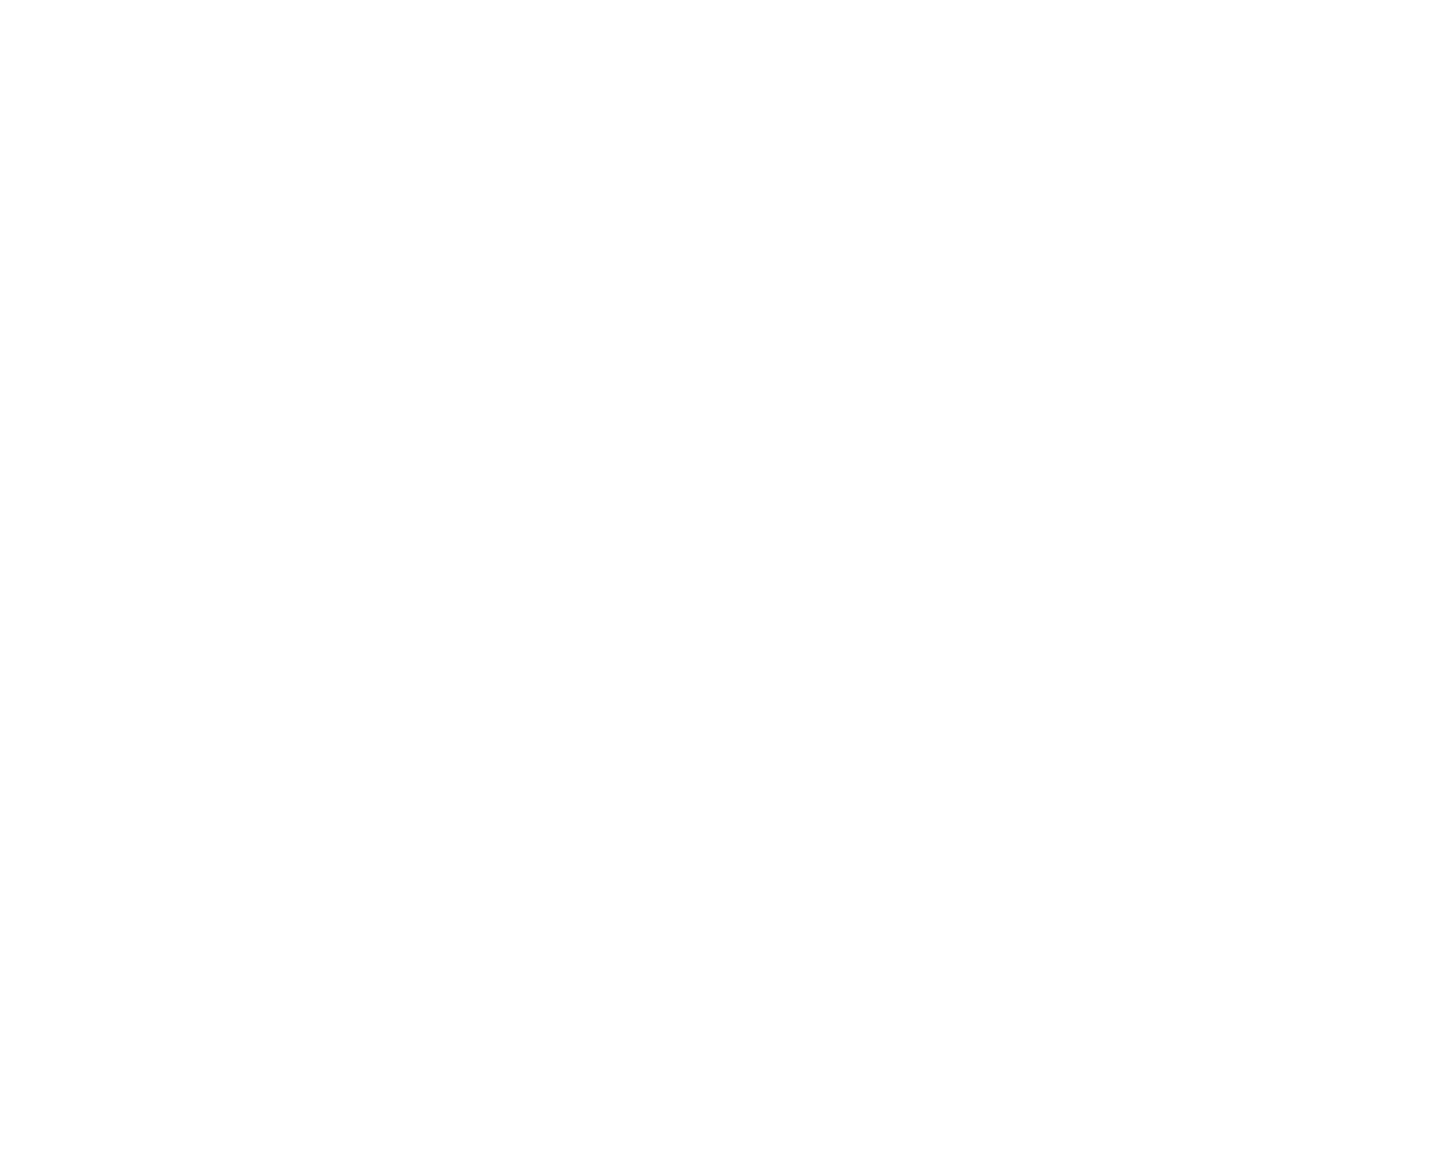

<IPython.core.display.Javascript object>


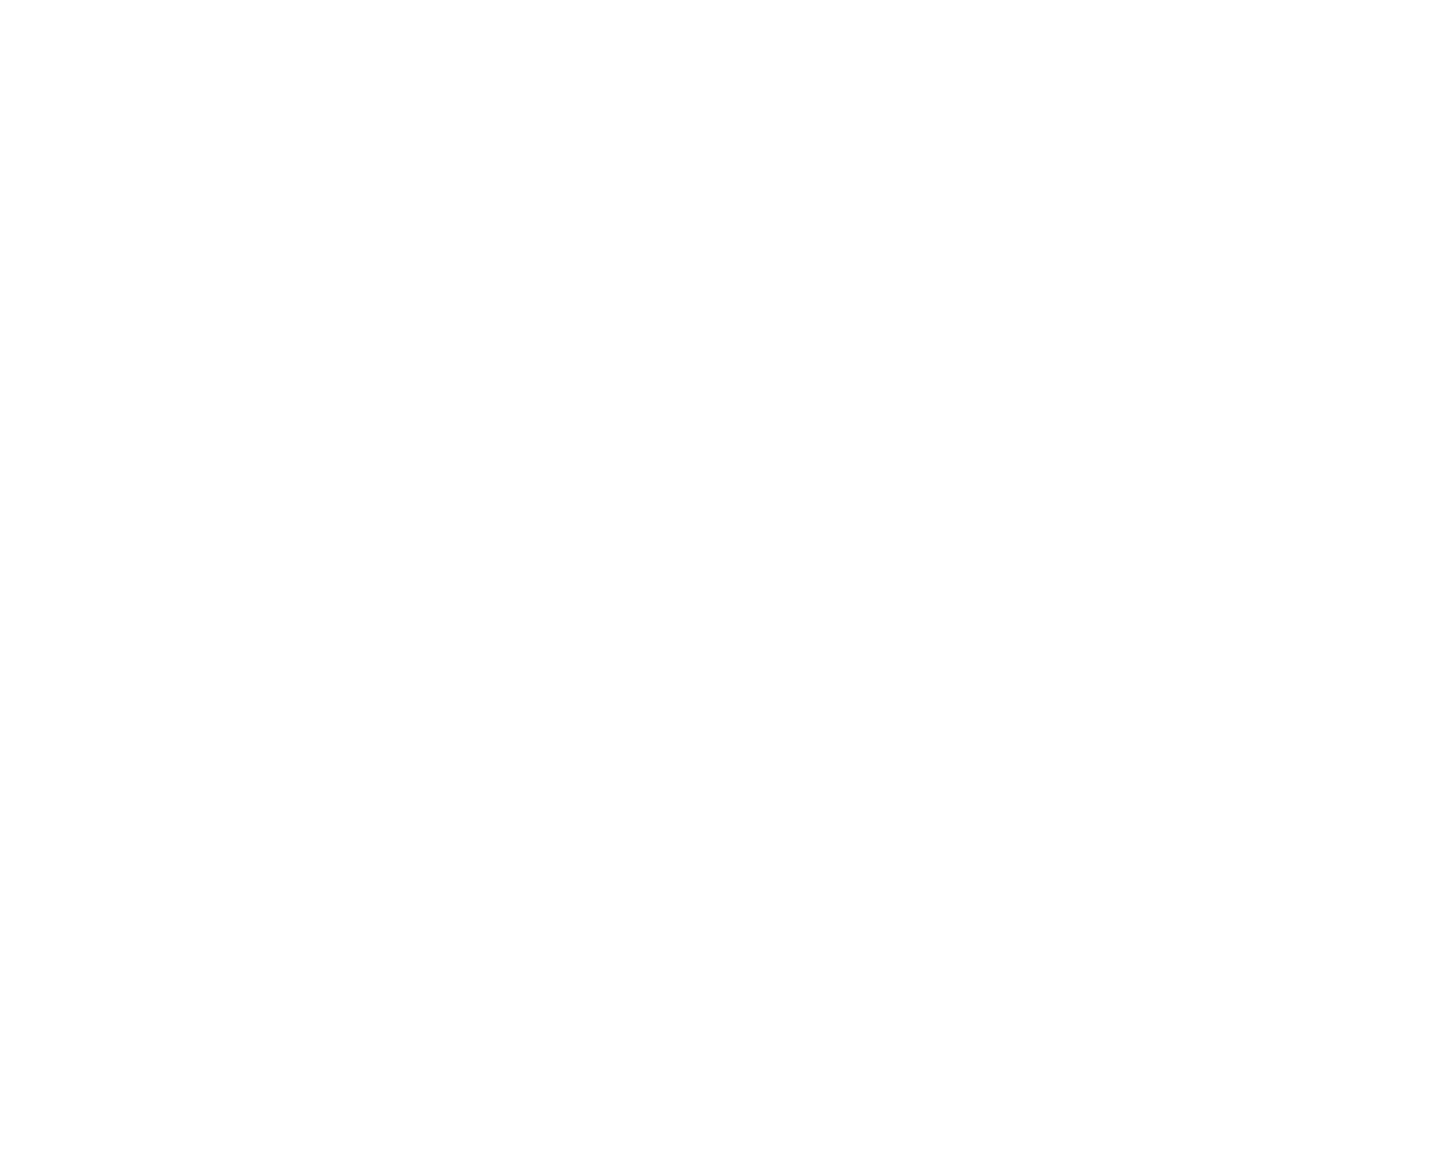

In [15]:
# now, we visualize these images before registration
display_2D_Images( fixedImage, movingImage )

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

from ipywidgets import interact, fixed
from IPython.display import clear_output

# Callback invoked by the interact IPython method for scrolling through the image stacks of
# the two images (moving and fixed).
def display_images(fixed_image_z, moving_image_z, fixed_npa, moving_npa):
    # Create a figure with two subplots and the specified size.
    plt.subplots(1,2,figsize=(10,8))
    
    # Draw the fixed image in the first subplot.
    plt.subplot(1,2,1)
    plt.imshow(fixed_npa[fixed_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('fixed image')
    plt.axis('off')
    
    # Draw the moving image in the second subplot.
    plt.subplot(1,2,2)
    plt.imshow(moving_npa[moving_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('moving image')
    plt.axis('off')
    
    plt.show()

# Callback invoked by the IPython interact method for scrolling and modifying the alpha blending
# of an image stack of two images that occupy the same physical space. 
def display_images_with_alpha(image_z, alpha, fixed, moving):
    img = (1.0 - alpha)*fixed[:,:,image_z] + alpha*moving[:,:,image_z] 
    plt.imshow(sitk.GetArrayViewFromImage(img),cmap=plt.cm.Greys_r);
    plt.axis('off')
    plt.show()
    
# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

# Callback invoked when the IterationEvent happens, update our data and display new figure.    
def plot_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()
    
# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the 
# metric_values list. 
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values)) 

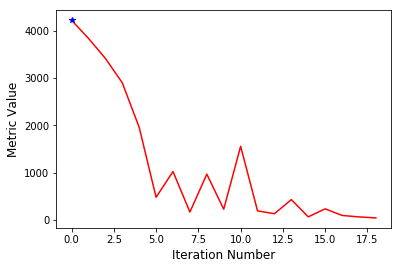

Final metric value: 75.13570253639905
Optimizer's stopping condition, RegularStepGradientDescentOptimizerv4: Step too small after 19 iterations. Current step (0.0078125) is less than minimum step (0.01).


In [17]:
registration_method = sitk.ImageRegistrationMethod()

# Similarity metric settings,
registration_method.SetMetricAsMeanSquares()

# interpolator
registration_method.SetInterpolator( sitk.sitkLinear )

# Optimizer setting
maxStep = 4.0
minStep = 0.01
numberOfIterations = 200
relaxationFactor = 0.5
registration_method.SetOptimizerAsRegularStepGradientDescent( maxStep, minStep, numberOfIterations, relaxationFactor )

# transform
initial_transform = sitk.TranslationTransform( fixedImage.GetDimension() )
initial_transform = sitk.Euler2DTransform()
initial_transform.SetCenter( [110.5, 128.5] )

# 1st option relates to rotation
registration_method.SetOptimizerScales( [1.0/0.35, 1.0/100.0, 1.0/100.0] )

registration_method.SetInitialTransform( initial_transform )

# Connect all of the observers so that we can perform plotting during registration.

#
# the registration_gui does not work for some reasons, so we use an alternative
registration_method.AddCommand(sitk.sitkStartEvent, rgui.start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, rgui.end_plot)
registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, rgui.update_multires_iterations) 
registration_method.AddCommand(sitk.sitkIterationEvent, lambda: rgui.plot_values(registration_method))

# Connect all of the observers so that we can perform plotting during registration.
registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))


final_transform = registration_method.Execute( fixedImage, movingImage )

# Always check the reason optimization terminated.
print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))

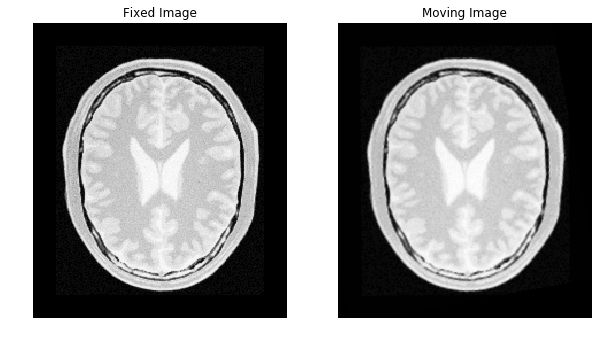

In [18]:
moving_resamples = sitk.Resample( movingImage, final_transform, sitk.sitkLinear, 0.0, movingImage.GetPixelID() )
display_2D_Images( fixedImage, moving_resamples )

In [19]:
print(final_transform)


# if we are satisfied with the result, save the transform
sitk.WriteTransform( final_transform, os.path.join( OUTPUT_DIR, 'Euler2D.tfm' ))

itk::simple::Transform
 Euler2DTransform (0x7fba9b8f7f30)
   RTTI typeinfo:   itk::Euler2DTransform<double>
   Reference Count: 3
   Modified Time: 2944
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     0.983171 -0.18269 
     0.18269 0.983171 
   Offset: [38.3398, -2.03211]
   Center: [110.5, 128.5]
   Translation: [13.0045, 15.9926]
   Inverse: 
     0.983171 0.18269 
     -0.18269 0.983171 
   Singular: 0
   Angle       = 0.183722



At first attemp, it appears that there is something wrong. The registration returns a metric of $0$ and did not proceed.

Remove the '#' sign from the transformation and to set the center of rotation, and run the registration again. What's happening?

**It doesn't quite work still!!** 

* why?
* remove the '#' sign from optimization scale and try again

<a href="AIP_Day_19_Rigid_Spatial_Transformation.ipynb"><h2 align=right>Next &raquo;</h2></a>